# HOW TO obtain archival ESO data given RA and Dec

The [ESO archive](http://archive.eso.org/cms.html) currently (June 2020) contains more than [1.7 million spectra](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=SPECTRUM&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22SPECTRUM%22%3atrue%7d&at=119.452774,-60.30286&sr=i), more than [650,000 images](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=IMAGE&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22IMAGE%22%3atrue%7d&at=160.465004,19.501825&sr=i), and more than [240,000 cubes](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=CUBE&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22CUBE%22%3atrue%7d&at=239.591811,-14.166308&sr=i).

There are three main ways to access the vaste amount of information present in the ESO archive, depending on the needs of an user:
* the [Raw Data query form](http://archive.eso.org/eso/eso_archive_main.html)
* the [Science Portal](http://archive.eso.org/scienceportal/home) to browse and access the processed data
* the [Programmatic and Tools access](http://archive.eso.org/programmatic/) which permits direct database access to both raw and processed data, and to the ambient condition measurements

The `archive_observations` module part of the (unofficial) [ESOAsg](https://github.com/EmAstro/ESOAsg) package provides simple wrappers to efficiently embed the access to the ESO archive to python routines.

With this example, we show how to obtain all science spectra associated to an object for which the location in the sky is known. 

In case you use data from the ESO Archive for your research, please consider the [ESO acknowledgement policies](http://archive.eso.org/cms/eso-data-access-policy.html#acknowledgement).

In [4]:
%matplotlib notebook

In [5]:
%load_ext autoreload
%autoreload 2

In [30]:
from ESOAsg.ancillary import astro
from ESOAsg.core import archive_observations

from astropy.coordinates import SkyCoord
from astropy.io import fits
import matplotlib.pyplot as plt

## Get RA and Dec of one target (or more)

To begin, you need to choose the targets you would like to explore and get their coordinates. These needs to be an [astropy.coordinates](https://docs.astropy.org/en/stable/coordinates/) `SkyCoord` object. A `SkyCoord` object can easily be created by using:
```python
from astropy import units as u
from astropy.coordinates import SkyCoord
coordinates = SkyCoord(ra=10.625*u.degree, dec=41.2*u.degree, frame='icrs')
```
For this example, we consider a couple of standard stars observed as part of the [`MUSE library of stellar spectra`](https://www.eso.org/sci/publications/announcements/sciann17288.html) project ([Ivanov et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...629A.100I/abstract)): 
* [HD 057060](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD+057060&submit=SIMBAD+search)
* [HD 172230](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD+172230&submit=SIMBAD+search).

The coordinates of these two stars are can be retrieved from their name using `Sesame`:

In [7]:
HD057060_position = SkyCoord.from_name('HD 057060')
HD172230_position = SkyCoord.from_name('HD 172230')
print('HD 057060: {}'.format(HD057060_position.to_string('hmsdms')))
print('HD 172230: {}'.format(HD172230_position.to_string('hmsdms')))

HD 057060: 07h18m40.3797s -24d33m31.3118s
HD 172230: 18h38m54.9544s +06d16m14.8348s


## Query the archive

`query_from_radec` allows to query for Archive Data Products (in short, ADPs) within a certain radius in arcseconds (e.g., radius=5.) from a given position (e.g., for HD 057060: RA=109.66824871, Dec=-24.55869773). The user can also limit the search to specific instruments, using the `instrument` option (e.g., 'MUSE' and 'XSHOOTER').

In practice, this corresponds to run the [TAP query](http://archive.eso.org/programmatic/&#35;TAP?f=application/x-votable+xml;serialization=TABLEDATA&m=200&q=SELECT%0A%20%20%20%20target_name%2C%20dp_id%2C%20s_ra%2C%20s_dec%2C%20t_exptime%2C%20em_min%2C%20em_max%2C%20%0A%20%20%20%20dataproduct_type%2C%20instrument_name%2C%20obstech%2C%20abmaglim%2C%0A%20%20%20%20proposal_id%2C%20obs_collection%0AFROM%0A%20%20%20%20ivoa.ObsCore%0AWHERE%0A%20%20%20%20CONTAINS&#40;s_region%2CCIRCLE&#40;'ICRS'%2C109.66824871%2C-24.55869773%2C5.0%2F3600.&#41;&#41;%3D1%0AAND%0A%20%20%20%20&#40;instrument_name%3D'MUSE'%20OR%20instrument_name%3D'XSHOOTER'&#41;&):

```SQL
SELECT
    target_name, dp_id, s_ra, s_dec, t_exptime, em_min, em_max, 
    dataproduct_type, instrument_name, obstech, abmaglim,
    proposal_id, obs_collection
FROM
    ivoa.ObsCore
WHERE
    CONTAINS(s_region,CIRCLE('ICRS',109.66824871,-24.55869773,5.0/3600.))=1
AND
    (instrument_name='MUSE' OR instrument_name='XSHOOTER')
```

In [8]:
position_list = [HD057060_position, HD172230_position]
result_from_queries = archive_observations.query_from_radec(position_list, radius=5., instruments=['MUSE', 'XSHOOTER'],
                                                           verbose=False)

[WORKING] :: Running query 1 to the ESO archive (out of 2 total)
[INFO]    :: A total of 4 entries has been retrieved
[WORKING] :: Running query 2 to the ESO archive (out of 2 total)
[INFO]    :: A total of 7 entries has been retrieved


The results are stored in a list of astropy tables (one table per position). For instance, for HD 057060:

In [9]:
result_from_queries[0].show_in_notebook(show_row_index=False)

target_name,dp_id,s_ra,s_dec,t_exptime,em_min,em_max,dataproduct_type,instrument_name,obstech,abmaglim,proposal_id,obs_collection
,,deg,deg,s,m,m,,,,mag,,
2MASS-J07184037-2433312,ADP.2017-06-02T19:41:04.876,109.668427,-24.55842,0.4,5.336599999999999e-07,1.02e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,OFFSET",--,084.B-0869(B),XSHOOTER
2MASS-J07184037-2433312,ADP.2017-06-02T19:41:04.929,109.668427,-24.55842,4.0,9.9402e-07,2.47896e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,OFFSET",--,084.B-0869(B),XSHOOTER
2MASS-J07184037-2433312,ADP.2017-06-02T19:41:04.937,109.668427,-24.55842,0.4,2.9892000000000003e-07,5.5598e-07,spectrum,XSHOOTER,"ECHELLE,SLIT,OFFSET",--,084.B-0869(B),XSHOOTER
HD 057060,ADP.2020-02-26T15:36:25.254,109.668254,-24.558703,0.9,4.74969e-07,9.34969e-07,spectrum,MUSE,IFU,--,099.D-0623(A),MUSE-STD


### Archive Science Portal Query:

If you are intrested, you can also check the result of the query in the [Archive Science Portal](http://archive.eso.org/scienceportal/home). After running:

```python
archive_observations.query_ASP_from_radec(position_list, radius=5., open_link=True)
```
you should see different ASP pages opening in your broswer (one per positions) pointing to the different regions of the sky you are quering.

In [12]:
archive_observations.query_ASP_from_radec(position_list, radius=5., open_link=True)

## Download the Archive Data Products

Now it is time to download the ADPs that you are interested in. This is done by passing the the `dp_id` of the results ti `archive_observations.download`.

In this case, we are interested only to the optical data for `HD 057060`, so we limit to:

`4.0e-7<em_max<1.2e-6`

(where the limits in wavelength are expressed in meters)

In [82]:
mask_optical = ( result_from_queries[0]['em_max'].data.data < 1.2e-6 ) & \
    ( result_from_queries[0]['em_min'].data.data > 4.0e-7 )
archive_observations.download(result_from_queries[0]['dp_id'][mask_optical])

[INFO]    :: Your disk has: Total: 397.03 GB, Used: 397.03 GB, Free: 397.03 GB
[WORKING] :: Downloading file ADP.2017-06-02T19:41:04.876.fits. This may take some time.
[INFO]    :: File ADP.2017-06-02T19:41:04.876.fits downloaded.
[WORKING] :: Downloading file ADP.2020-02-26T15:36:25.254.fits. This may take some time.
[INFO]    :: File ADP.2020-02-26T15:36:25.254.fits downloaded.


## Explore the data

Now the `MUSE` and `XSHOOTER` optical spectra of `HD 057060` are on our disk and you can explore them with your favourite tools. For instance, it is possible to compare the different shape of the two spectra due (probably) to slit-losses.

Content of the MUSE spectrum: 
 ColDefs(
    name = 'WAVE'; format = '3681D'; unit = 'angstrom'
    name = 'FLUX'; format = '3681D'; unit = 'erg.s**(-1).cm**(-2).angstrom**(-1)'
    name = 'ERR'; format = '3681D'; unit = 'erg.s**(-1).cm**(-2).angstrom**(-1)'
) 

Content of the XSHOOTER spectrum: 
 ColDefs(
    name = 'WAVE'; format = '24318D'; unit = 'nm'
    name = 'FLUX'; format = '24318D'; unit = 'erg cm**(-2) s**(-1) angstrom**(-1)'
    name = 'ERR'; format = '24318D'; unit = 'erg cm**(-2) s**(-1) angstrom**(-1)'
    name = 'QUAL'; format = '24318J'
    name = 'SNR'; format = '24318D'
    name = 'FLUX_REDUCED'; format = '24318D'; unit = 'adu'
    name = 'ERR_REDUCED'; format = '24318D'; unit = 'adu'
) 



<IPython.core.display.Javascript object>


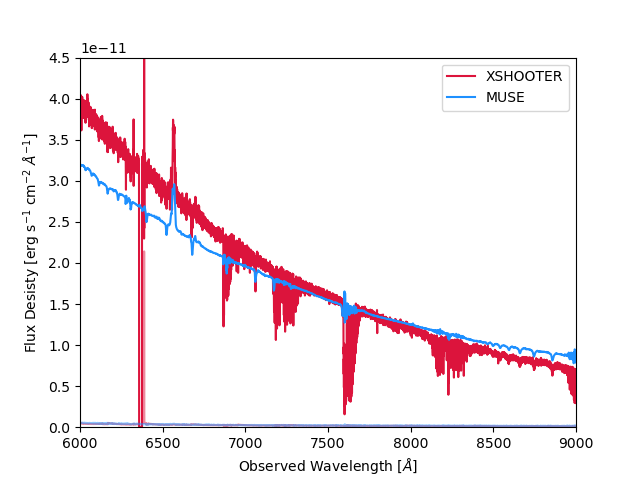

In [83]:
spectrum_muse = fits.open('ADP.2020-02-26T15:36:25.254.fits')[1]
print('Content of the MUSE spectrum: \n {} \n'.format(spectrum_muse.columns))

spectrum_xshooter = fits.open('ADP.2017-06-02T19:41:04.876.fits')[1]
print('Content of the XSHOOTER spectrum: \n {} \n'.format(spectrum_xshooter.columns))

plt.figure()
plt.plot(10.*spectrum_xshooter.data['WAVE'][0], 10.*spectrum_xshooter.data['FLUX'][0], label=r'XSHOOTER', c='crimson')
plt.plot(10.*spectrum_xshooter.data['WAVE'][0], 10.*spectrum_xshooter.data['ERR'][0], c='crimson', alpha=0.5)
plt.plot(spectrum_muse.data['WAVE'][0], spectrum_muse.data['FLUX'][0], label=r'MUSE', c='dodgerblue')
plt.plot(spectrum_muse.data['WAVE'][0], spectrum_muse.data['ERR'][0], c='dodgerblue', alpha=0.5)
plt.xlim(6000., 9000.)
plt.ylim(0., 0.45e-10)
plt.xlabel(r'Observed Wavelength [$\AA$]')
plt.ylabel(r'Flux Desisty [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
plt.legend()
plt.show()
plt.savefig('HD057060.jpg', format='jpg', quality=99, bbox_inches='tight')

## All in one
The same resuls are achievable with the (un-official) ESOAsg script:
```python
get_data_from_radec.py
```